In [1]:
#import necessary libraries
using QuantumCumulants
using OrdinaryDiffEq
using ModelingToolkit
using PyPlot
using Random
using DelimitedFiles

In [2]:
M=2 #choose order of cumulant expansion
NCl=5; #Number of atom clusters

In [3]:
#define symbolic parameters
@cnumbers K Δ g κ Γ R ν t σv
v=[cnumbers(Symbol(:v, i))[1] for i=1:NCl];

In [4]:
#define atom trajectories
x0=[i/NCl for i=1:NCl]
xt=[x0[i]+v[i]*t for i=1:NCl]
phit=xt*2pi;

In [5]:
#define Hilbert space
hc=FockSpace(:cavity)
ha_2l(i) = NLevelSpace(Symbol(:atom, i), 2)
ha_clust(i) = ClusterSpace(ha_2l(i), K, M)

ha_clust (generic function with 1 method)

In [6]:
ha = ⊗([ha_clust(i) for i=1:NCl]...)
h = hc ⊗ ha;

In [7]:
# operators
@qnumbers a::Destroy(h)
σ(i, j, k) = Transition(h, Symbol(:σ, k), i, j, k+1)

σ (generic function with 1 method)

In [8]:
#define Hamiltonian
H = Δ*a'*a + sum([g*cos(phit[i])*(a'*sum(σ(1,2,i))+a*sum(σ(2,1,i))) for i=1:NCl]);

In [9]:
#Lindblad terms for dissipative processes
J = [a; [σ(1,2,i) for i=1:NCl];[σ(2,1,i) for i=1:NCl];]
rates = [κ; [Γ for i=1:NCl]; [ν for i=1:NCl];];

In [10]:
# Derive equations
ops = [a'*a] #for this operator(s) the equations will be derived
eqs = meanfield(ops,H,J; rates=rates, iv=t, order=M);

In [11]:
#custom filter function (only relevant for 2nd order)
φ(x::Average) = φ(x.arguments[1])
φ(::Destroy) = -1
φ(::Create) = 1
φ(x::QTerm) = sum(map(φ, x.args_nc))
φ(x::Transition) = x.i - x.j
phase_invariant(x) = iszero(φ(x))

phase_invariant (generic function with 1 method)

In [12]:
#Complete equations starting with equation for ops
#eqs_c = complete(eqs; filter_func=phase_invariant) #use this for 2nd order
eqs_c = complete(eqs, multithread=true, filter_func=phase_invariant); #use this for mean field

In [13]:
#define ODE system, which can be solved numerically
sys = ODESystem(eqs_c);

In [14]:
#define function giving the solution, depending on parameters
function photnumbevo(T_end, K_, ν_, σv_, i, γ_, g_)

u0=[0.01 + 0.0*im for i=1:length(eqs_c)]
κ_ = 1
Δ_ = 0
Random.seed!(i) #allows us to have the same random distribution for the same i 
v_=[randn()*σv for i=1:NCl]    
ps=[K, Δ, g, κ, Γ, ν, σv, v...]
p0=[K_, Δ_, g_, κ_, γ_, ν_, σv_, v_...]

prob=ODEProblem(sys, u0, (0.0, T_end), ps.=>p0);
sol = solve(prob, Tsit5(), abstol=1e-10, reltol=1e-10, saveat=0.1);
    return sol[a'*a]
end

photnumbevo (generic function with 1 method)

In [15]:
#calculate a result
res=photnumbevo(400, 200000, 0.5, 0.0, 1, 0, 0.00136);

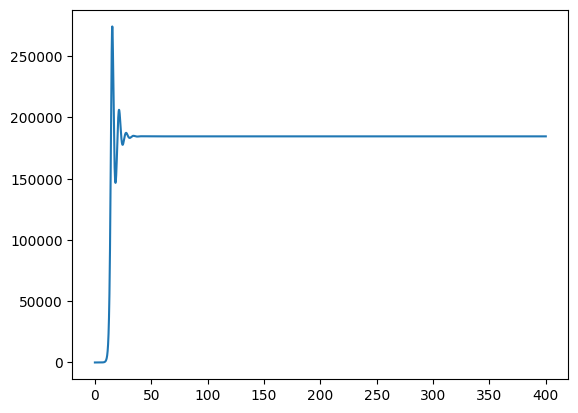

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fcee79e8280>

In [16]:
#plotting
tarr=collect(0.0:0.1:400)
plot(tarr, res)